# Basic Image Classifier

Model is trained on CIFAR-100 dataset. It is a CNN model and it learns relevant visual features such as edges, textures, shapes from the images and uses those to predict the most likely class for any new image. 

There are 20 categories for the images:  

    aquatic mammals, fish, flowers, food containers, fruit and vegetables, household electrical devices, household furniture, insects, large carnivores, large man-made outdoor things, large natural outdoor scenes, large omnivores and herbivores, medium-sized mammals, non-insect invertebrates, people, reptiles, small mammals, trees, vehicles 1, vehicles 2.

There are 100 labels for the images:  

    apple, aquarium_fish, baby, bear, beaver, bed, bee, beetle, bicycle, bottle,
    bowl, boy, bridge, bus, butterfly, camel, can, castle, caterpillar, cattle,
    chair, chimpanzee, clock, cloud, cockroach, couch, cra, crocodile, cup, dinosaur,
    dolphin, elephant, flatfish, forest, fox, girl, hamster, house, kangaroo, keyboard,
    lamp, lawn_mower, leopard, lion, lizard, lobster, man, maple_tree, motorcycle, mountain,
    mouse, mushroom, oak_tree, orange, orchid, otter, palm_tree, pear, pickup_truck, pine_tree,
    plain, plate, poppy, porcupine, possum, rabbit, raccoon, ray, road, rocket, rose,
    sea, seal, shark, shrew, skunk, skyscraper, snail, snake, spider, squirrel, streetcar,
    sunflower, sweet_pepper, table, tank, telephone, television, tiger, tractor, train, trout,
    tulip, turtle, wardrobe, whale, willow_tree, wolf, woman, worm

In [2]:
import torchvision
import torchvision.transforms as transforms

In [3]:
#transform: convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.507, 0.487, 0.441), (0.267, 0.256, 0.276))
])

#Download and load the training data
training_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testing_set = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

#Create data loaders
from torch.utils.data import DataLoader
train_loader = DataLoader(training_set, batch_size=64, shuffle=True)
test_loader = DataLoader(testing_set, batch_size=64, shuffle=False)

100%|██████████| 169M/169M [00:25<00:00, 6.51MB/s] 


In [6]:
#A simple Convolutional Neural Network Model (CNN)
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 100)  # 100 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (32x32 → 16x16)
        x = self.pool(F.relu(self.conv2(x)))  # (16x16 → 8x8)
        x = x.view(-1, 64 * 8 * 8)            # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
#Loss function and optimizer
import torch.optim as optim

model = SimpleCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss() #loss function for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/10, Loss: 502.3506, Accuracy: 80.68%
Epoch 2/10, Loss: 405.4880, Accuracy: 84.14%
Epoch 3/10, Loss: 344.3981, Accuracy: 86.23%
Epoch 4/10, Loss: 295.1753, Accuracy: 87.99%
Epoch 5/10, Loss: 249.7117, Accuracy: 89.72%
Epoch 6/10, Loss: 217.4066, Accuracy: 91.13%
Epoch 7/10, Loss: 195.4956, Accuracy: 91.82%
Epoch 8/10, Loss: 176.1409, Accuracy: 92.59%
Epoch 9/10, Loss: 172.8580, Accuracy: 92.74%
Epoch 10/10, Loss: 162.1453, Accuracy: 93.14%


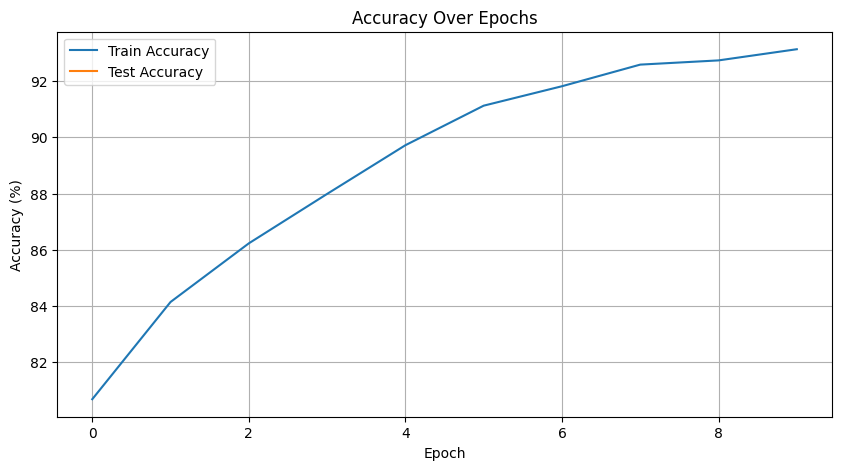

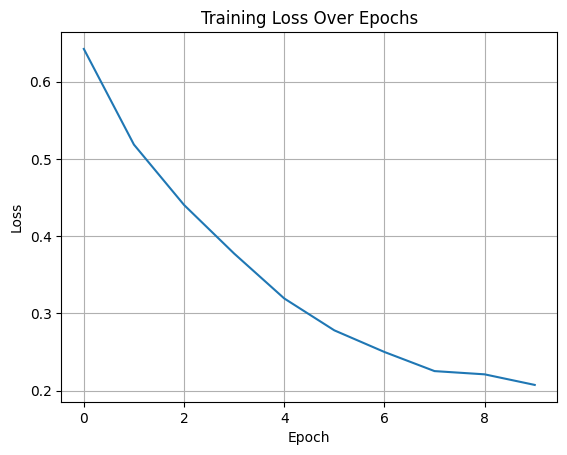

In [15]:
#Training Loop for Gradient Descent
import matplotlib.pyplot as plt

train_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)


    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")

#Plot curves for training loss and accuracy
plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

#Plot training loss
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [17]:
#Evaluation on the test set represented by test accuracy.
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()

    test_acc = 100 * correct_test / total_test
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.2f}% | Test Acc: {test_acc:.2f}%")

# Save the model
torch.save(model.state_dict(), 'cifar100_cnn.pth')

Epoch 10/10 | Train Loss: 0.2073 | Train Acc: 93.14% | Test Acc: 34.87%


We can see the test accuracy is much lower than the Training accuracy this is a classic indication of overfitting as the training accuracy is very high.